<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-11%5D%ED%8F%90%EB%A0%B4%EC%A7%84%EB%8B%A8%20%EC%84%B1%EB%8A%A5%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행해보자.

**augmentation 기법**을 고려해 볼 수 있다. **그러나 의료 영상인 경우,** 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 **부수효과가 오히려 방해를 줄 수도 있기 때문에 augmentation 도입은 신중해야 한다.**

따라서 좌우 반전 정도의 augmentation만 도입하였다.

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(10)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

In [ ]:
# 정상 이미지와 폐렴 이미지를 구분하기 위해 파일경로를 사용
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1164_bacteria_3110.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person771_virus_1399.jpeg


In [ ]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1089
Pneumonia images count in training set: 3096


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train, validation 데이터셋 개수 확인

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

[텐서와 연산 - .numpy()](https://www.tensorflow.org/tutorials/customization/basics?hl=ko)
- numpy배열로 변환함

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
- 학습용 데이터를 시각화해서 확인해 보기

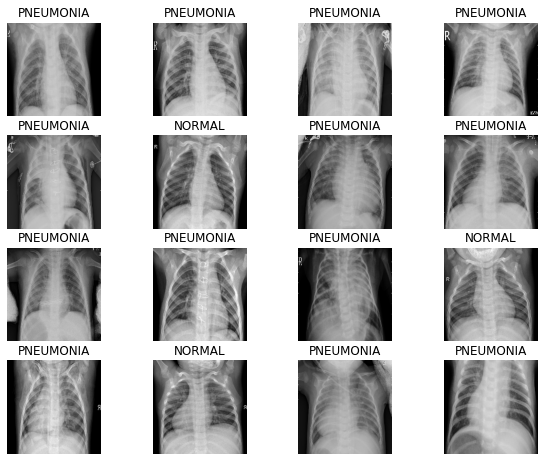

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
CNN모델을 구성할 때 Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있다.

**BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 구성은 일반적으로 잘 사용되는 형태는 아니다다.** 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다.BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 또한 Dropout 비율을 변경해보는 등의 시도를 해볼 것이다.

### Convolution 블록
- Convolution을 두 번 진행하고
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다.
- 그리고 Max Pooling을 한다.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense 블록

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 모델 구성 함수

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

### 모델1
- batch normalization과 Drop out 동시에 적용

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_path =  ROOT_PATH + '/chest_xray/Xray_img_classification.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=7)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        #callbacks=[checkpoint, early_stopping]
    )

Epoch 1/25
261/261 [==============================] - 53s 133ms/step - loss: 0.5166 - accuracy: 0.7092 - precision: 0.8763 - recall: 0.6951 - val_loss: 1.5980 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 128ms/step - loss: 0.2138 - accuracy: 0.9181 - precision: 0.9805 - recall: 0.9080 - val_loss: 1.9534 - val_accuracy: 0.7519 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1793 - accuracy: 0.9264 - precision: 0.9820 - recall: 0.9163 - val_loss: 2.8432 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1332 - accuracy: 0.9407 - precision: 0.9834 - recall: 0.9357 - val_loss: 1.3301 - val_accuracy: 0.4010 - val_precision: 1.0000 - val_recall: 0.2013
Epoch 5/25
261/261 [==============================] - 33s 128ms/step - loss: 0.1245 - accura

### 모델2
- batch normalization만 적용 (위 함수들 수정 후 실행함)
- callback함수로 val_loss가 가장 낮은 모델 저장

In [ ]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
sequential_3 (Sequential)    (None, 5, 5, 256)        

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_loss',
                             save_best_only=True)]

with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/25
261/261 [==============================] - 55s 134ms/step - loss: 0.4936 - accuracy: 0.7504 - precision: 0.9318 - recall: 0.7109 - val_loss: 0.6151 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 129ms/step - loss: 0.2339 - accuracy: 0.9088 - precision: 0.9689 - recall: 0.9063 - val_loss: 1.1169 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2015 - accuracy: 0.9203 - precision: 0.9782 - recall: 0.9140 - val_loss: 0.0868 - val_accuracy: 0.9712 - val_precision: 0.9712 - val_recall: 0.9910
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1558 - accuracy: 0.9392 - precision: 0.9845 - recall: 0.9332 - val_loss: 0.3676 - val_accuracy: 0.8058 - val_precision: 0.7951 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1682 - accura

# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

### 모델1

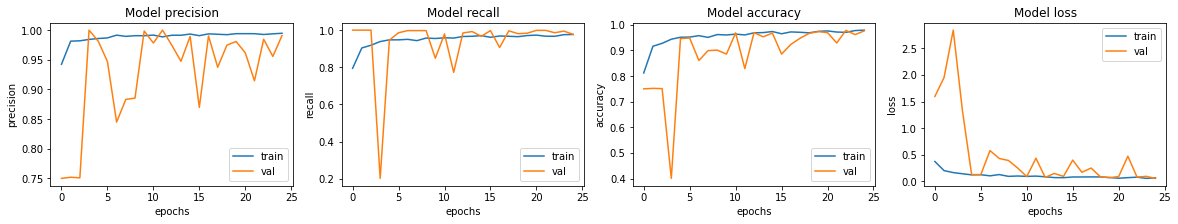

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 1.4226 - accuracy: 0.7885 - precision: 0.7529 - recall: 0.9846
Loss: 1.4226278066635132,
Accuracy: 0.7884615659713745,
Precision: 0.7529411911964417,
Recall: 0.9846153855323792


### 모델2

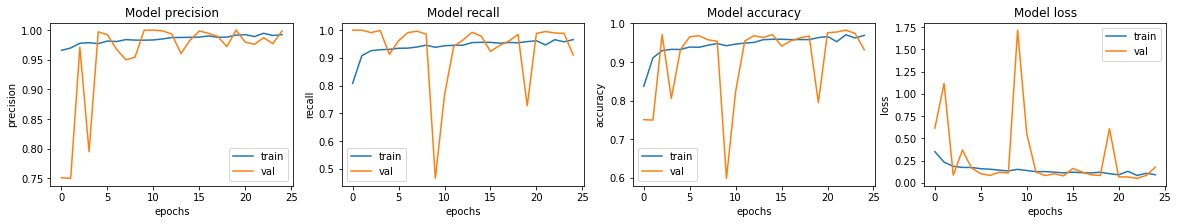

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.5342 - accuracy: 0.8782 - precision: 0.8905 - recall: 0.9179
Loss: 0.5341589450836182,
Accuracy: 0.8782051205635071,
Precision: 0.8905472755432129,
Recall: 0.9179487228393555


recall은 모델1보다 조금 떨어졌지만, accuracy가 87%로 많이 개선되었다.

# 루브릭

1.의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

2.데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
- regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

3.실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
- Accuracy 기준 85%에 도달하였다.

# 회고
모델을 구성할 때 함수를 호출하는 방식은 익숙하지 않았는데 이번에 함수로 층을 쌓아보며 하이퍼파라미터 조정도 비교적 쉽고 이해도 잘 되는 것 같다. 평소에 함수를 정의하여 구현하는 방식이 익숙하지 않았는데 exploration노드들을 하면서 이런 연습도 할 수 있어서 좋았다.

근데 여기서 궁금한 점은 함수로 Conv블록을 생성하니까 model.summary()에는 Sequential로 하나의 덩어리로만 보인다. plot_model로 출력한 결과도 model.summary()와 같다. 어떻게 확인할 수 있는지 그리고 이렇게 보여도 제대로 Convolution블록이 동작하고 있는게 맞는지 궁금하다.

처음에 겪었던 문제는 초반에 lable.numpy()가 자꾸 False가 뜨는 현상이었다. 그런데 갑자기 True가 나와서 이 문제의 원인과 해결방법을 모르겠다..

학습한 모델의 val_loss가 매우 오락가락 하는 현상을 발견했다. 데이터 때문일까? 아니면 batch_size를 다르게 하면 개선이 되는 걸까?<br>
그리고 이러한 현상때문에 처음에는 early stop을 설정 후 학습시켰었는데 학습이 너무 빨리 종료되다보니 그냥 이러한 조건 없이 학습시키는게 나을 것 같았다. 그래도 early stop을 제외하고 epoch을 모두 마칠동안 학습시키면 오락가락하는 정도가 점차 줄어든다. 즉 어느정도 최적값에 수렴하는 모습을 보였다.